In [7]:
# Cell 1: Setup
# Run this cell first. On Kaggle, enable "Accelerator: GPU" in Settings.

# If running on Kaggle you probably already have most libs. Install extras:
!pip install --quiet category_encoders shap xgboost lightgbm catboost optuna joblib

# Imports
import os, sys, gc, json, time, joblib, pathlib
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix
from category_encoders import TargetEncoder
import shap

# ML models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# quick gpu check
print("CUDA / NVIDIA GPU availability (nvidia-smi):")
!nvidia-smi || true


CUDA / NVIDIA GPU availability (nvidia-smi):
Mon Oct 20 06:52:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--

In [2]:
import pandas as pd
data = pd.read_csv("/kaggle/input/diabetes-aws/diabetic_data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
# Cell 2: Unpack and load CSVs (adapt paths as needed)
DATA_DIR = Path('/kaggle/input/diabetes-aws')  # adapt if different
raw_zip = list(DATA_DIR.glob('*.zip'))
print("Zip candidates:", raw_zip[:3])

# If unzipped manually or files are directly available:
diab_path = DATA_DIR / 'diabetic_data.csv'
ids_path = DATA_DIR / 'IDs_mapping.csv'  # filenames vary: 'IDs_mapping.csv' or 'ids_mapping.csv'

# fallback: try to find plausible files
if not diab_path.exists():
    for f in DATA_DIR.glob('*diabetic*'):
        diab_path = f
if not ids_path.exists():
    for f in DATA_DIR.glob('*ID*map*'):
        ids_path = f

print("diabetic file:", diab_path.exists(), diab_path)
print("ids mapping:", ids_path.exists(), ids_path)

# load
df = pd.read_csv(diab_path)
ids_map = pd.read_csv(ids_path)
print("Shape:", df.shape)
display(df.head(3))
display(ids_map.head(5))


Zip candidates: []
diabetic file: True /kaggle/input/diabetes-aws/diabetic_data.csv
ids mapping: True /kaggle/input/diabetes-aws/IDS_mapping.csv
Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [10]:
# Cell 3: Basic cleaning
df = df.copy()
# common placeholder in this dataset is '?'
df.replace('?', np.nan, inplace=True)

# drop exact duplicates (if any)
n_before = len(df)
df.drop_duplicates(inplace=True)
print(f"dropped duplicates: {n_before - len(df)}")

# map readmitted to binary: <30 -> 1, NO or >30 -> 0
df['readmitted_binary'] = df['readmitted'].map(lambda x: 1 if str(x).strip() == '<30' else 0)
print("Value counts (binary):")
print(df['readmitted_binary'].value_counts())

# basic type fixups
print(df.dtypes.value_counts())


dropped duplicates: 0
Value counts (binary):
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64
object    37
int64     14
Name: count, dtype: int64


In [13]:
# Safe correlations and feature prepping

# Ensure target exists
assert 'readmitted_binary' in df.columns

# Remove identifier columns from feature lists
id_cols = ['encounter_id','patient_nbr']
for col in id_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        print(f"dropped id column: {col}")

# Recompute numeric/categorical lists properly
num_cols = df.select_dtypes(include=['int64','float64','float32','int32']).columns.tolist()
# exclude the target
if 'readmitted_binary' in num_cols:
    num_cols.remove('readmitted_binary')

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols example:", num_cols[:15])
print("Categorical cols example:", cat_cols[:15])

# Compute Spearman correlations robustly
# Use .loc on the correlation DataFrame to avoid ambiguous indexing
corr_df = df[num_cols + ['readmitted_binary']].corr(method='spearman')
# ensure row exists, then select the readmitted row and squeeze to Series
if 'readmitted_binary' in corr_df.index:
    corr_with_target = corr_df.loc['readmitted_binary'].drop('readmitted_binary', errors='ignore').sort_values(ascending=False)
else:
    # fallback - compute correlations column-wise explicitly
    corr_with_target = pd.Series({c: df[c].corr(df['readmitted_binary'], method='spearman') for c in num_cols}).sort_values(ascending=False)

print("\nTop positive numeric correlations with readmission:")
display(corr_with_target.head(10))

print("\nTop negative numeric correlations with readmission:")
display(corr_with_target.tail(10))


dropped id column: encounter_id
dropped id column: patient_nbr
Numeric cols example: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical cols example: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide']

Top positive numeric correlations with readmission:


number_inpatient            0.138382
discharge_disposition_id    0.064833
number_emergency            0.063438
time_in_hospital            0.050904
number_diagnoses            0.047230
num_medications             0.045423
number_outpatient           0.034169
num_lab_procedures          0.020564
admission_source_id         0.011763
num_procedures             -0.006113
Name: readmitted_binary, dtype: float64


Top negative numeric correlations with readmission:


discharge_disposition_id    0.064833
number_emergency            0.063438
time_in_hospital            0.050904
number_diagnoses            0.047230
num_medications             0.045423
number_outpatient           0.034169
num_lab_procedures          0.020564
admission_source_id         0.011763
num_procedures             -0.006113
admission_type_id          -0.013429
Name: readmitted_binary, dtype: float64

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple 

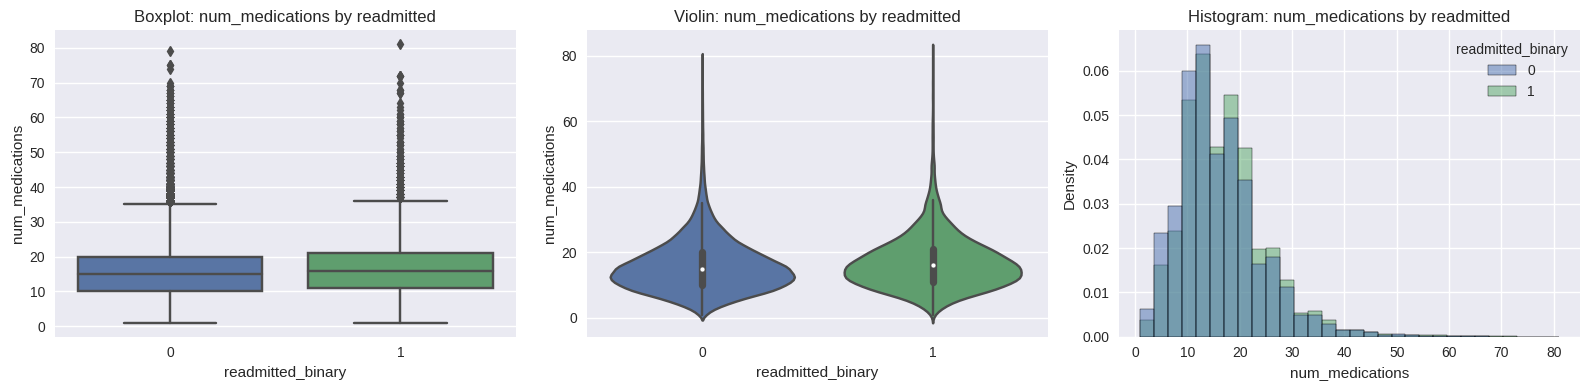

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


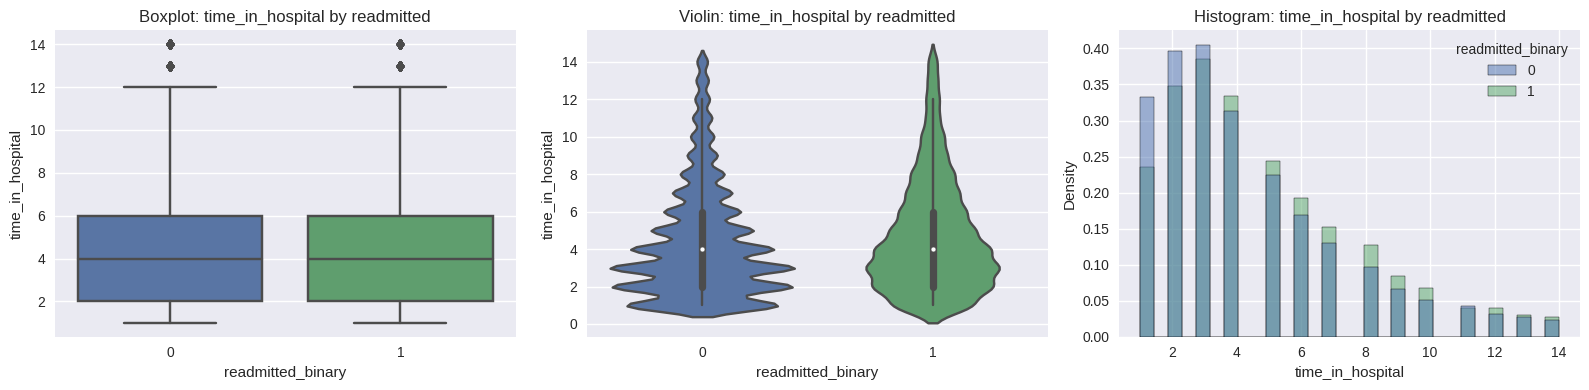

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


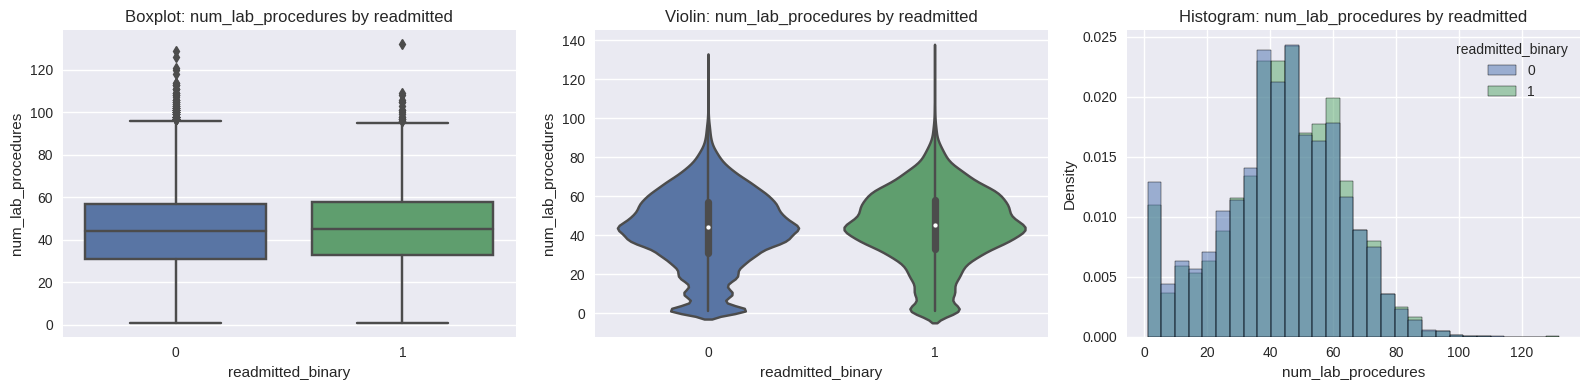

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


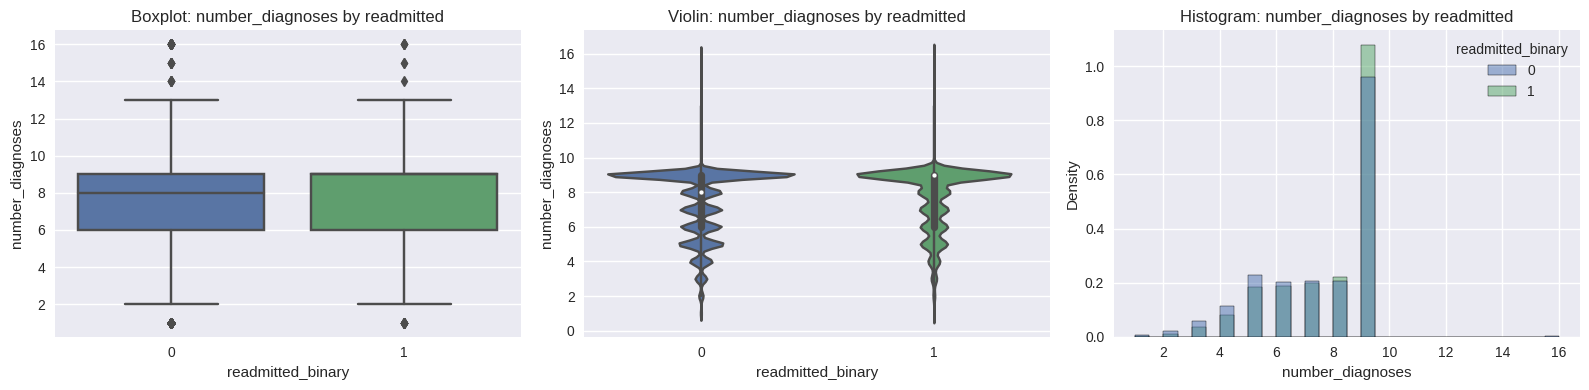

In [15]:
# Visual checks: distribution by target for key numeric features
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

def box_violin_hist(col, bins=30):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    sns.boxplot(x='readmitted_binary', y=col, data=df, ax=axs[0])
    sns.violinplot(x='readmitted_binary', y=col, data=df, ax=axs[1])
    sns.histplot(data=df, x=col, hue='readmitted_binary', bins=bins, stat='density', common_norm=False, ax=axs[2])
    axs[0].set_title(f"Boxplot: {col} by readmitted")
    axs[1].set_title(f"Violin: {col} by readmitted")
    axs[2].set_title(f"Histogram: {col} by readmitted")
    plt.tight_layout()
    plt.show()

for col in ['num_medications','time_in_hospital','num_lab_procedures','number_diagnoses']:
    if col in df.columns:
        box_violin_hist(col)


,age,count,mean
2,[20-30),1657,0.142426
8,[80-90),17197,0.120835
7,[70-80),26068,0.117731
3,[30-40),3775,0.112318
6,[60-70),22483,0.111284
9,[90-100),2793,0.110992
4,[40-50),9685,0.106040
5,[50-60),17256,0.096662
1,[10-20),691,0.057887
0,[0-10),161,0.018634


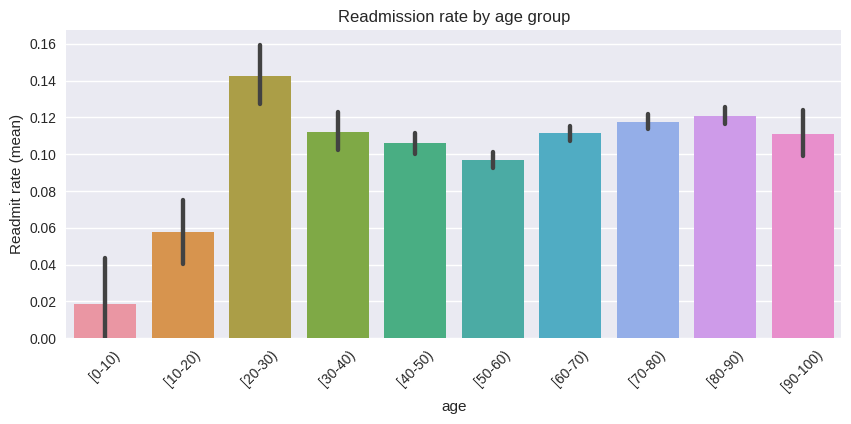

In [16]:
# Age group analysis (bar-chart of positive rate per age bucket)
if 'age' in df.columns:
    age_tab = df.groupby('age')['readmitted_binary'].agg(['count','mean']).reset_index().sort_values('mean',ascending=False)
    display(age_tab.head(10))
    plt.figure(figsize=(10,4))
    sns.barplot(data=df, x='age', y='readmitted_binary', order=sorted(df['age'].unique()))
    plt.ylabel('Readmit rate (mean)')
    plt.title('Readmission rate by age group')
    plt.xticks(rotation=45)
    plt.show()


In [12]:
# Cell 5: Explore ids mapping structure and apply mapping
display(ids_map.head(50))

# The ids file typically has columns mapping id -> description (e.g., admission_type_id -> description).
# Example approach: pivot or create dicts for known ids
# First inspect the unique id types (if present)
print(ids_map.columns)
# If mapping file is in form 'id','name','description', then make dict
# Example generic code (adjust according to actual ids_map structure):
for col in ids_map.columns:
    print(col, ids_map[col].nunique())

# Suppose ids_map has columns: 'table','value','description' (some variants). We'll make a general approach:
# Build mapping dicts for the three known code types if present.
mapping_dicts = {}
if {'table','code','description'}.issubset(set(ids_map.columns)):
    for table_name, g in ids_map.groupby('table'):
        mapping_dicts[table_name] = dict(zip(g['code'], g['description']))
    print("Built mapping for tables:", list(mapping_dicts.keys()))
else:
    # Many Kaggle copies store a simple mapping per id column as two columns.
    print("ids_map format is nonstandard; inspect and build mapping manually as needed.")


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


Index(['admission_type_id', 'description'], dtype='object')
admission_type_id 32
description 58
ids_map format is nonstandard; inspect and build mapping manually as needed.


In [17]:
# Cell 6: Feature engineering helper functions

def add_polypharmacy(df, threshold=8):
    # num_medications exists in this dataset
    df['polypharmacy'] = (df['num_medications'].fillna(0) > threshold).astype(int)
    return df

def diagnosis_to_chronic(df, diag_cols=['diag_1','diag_2','diag_3']):
    # Simple ICD grouping heuristics:
    # ICD codes starting with 250 are diabetes related; 390-459 cardiac; 800-999 injuries; 710-739 musculoskeletal; 520-579 gastrointestinal
    def map_icd(icd):
        if pd.isna(icd): return 'unknown'
        s = str(icd).strip()
        # remove leading non-numeric chars
        s2 = ''.join(ch for ch in s if (ch.isdigit() or ch=='.'))
        if s2=='':
            s2 = s
        # coarse mapping by prefix
        try:
            prefix = int(float(s2.split('.')[0]))
            if 1 <= prefix <= 139: return 'infectious'
            if 140 <= prefix <= 239: return 'neoplasm'
            if 240 <= prefix <= 279: return 'endocrine_metabolic'  # includes diabetes
            if 280 <= prefix <= 289: return 'blood'
            if 290 <= prefix <= 319: return 'mental'
            if 390 <= prefix <= 459: return 'circulatory'
            if 460 <= prefix <= 519: return 'respiratory'
            if 520 <= prefix <= 579: return 'digestive'
            if 710 <= prefix <= 739: return 'musculoskeletal'
            if 800 <= prefix <= 999: return 'injury'
        except:
            pass
        # fallback


In [18]:
# Cell 7: Preprocessing pipeline with ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Identify columns
all_cols = df.columns.tolist()
target_col = 'readmitted_binary'
ignore_cols = ['readmitted', 'readmitted_binary', 'encounter_id', 'patient_nbr']  # keep id cols out of training
# identify numerics
num_cols = df.select_dtypes(include=['int64','float64']).columns.difference(ignore_cols).tolist()
# remove integer flags that are actually categorical
# We'll manually prune a few known integer codes from numeric to categorical
maybe_cat = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for c in maybe_cat:
    if c in num_cols:
        num_cols.remove(c)
cat_cols = [c for c in df.select_dtypes(include=['object']).columns if c not in ignore_cols]

print("Numeric cols:", len(num_cols))
print("Categorical (object) cols:", len(cat_cols))
print("Sample cat cols:", cat_cols[:20])

# For high-cardinality categoricals we'll use TargetEncoder; for low-card use OneHotEncoder
# heuristic:
low_cardinality = [c for c in cat_cols if df[c].nunique() <= 20]
high_cardinality = [c for c in cat_cols if df[c].nunique() > 20]

from sklearn.pipeline import make_pipeline
# numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# low-card categorical: onehot
lowcat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# high-card categorical: target encoding (must be applied carefully inside CV to avoid leakage; we will apply CE.TargetEncoder inside CV loop)
highcard_cols = high_cardinality  # list

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('lowcat', lowcat_transformer, low_cardinality),
    # high-card handled separately in fold training via TargetEncoder (cannot be used inside ColumnTransformer safely across folds)
], remainder='drop', verbose_feature_names_out=False)

# quick test: fit transform small insample (only for pipeline structure check)
X_sample = df.drop(columns=ignore_cols + [target_col]).copy()
y_sample = df[target_col].copy()
# Note: we will not call preprocessor.fit_transform on full X until inside CV (to avoid leakage)
print("Preprocessor prepared.")


Numeric cols: 8
Categorical (object) cols: 36
Sample cat cols: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide']


KeyError: "['encounter_id', 'patient_nbr'] not found in axis"

In [ ]:
# Cell 8: CV training loop (will train XGBoost, LightGBM, CatBoost, RF, SVC, Logistic)
SEED = 42
N_SPLITS = 5
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

models_to_run = {
    "xgb": lambda: xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=6,
        tree_method='gpu_hist', predictor='gpu_predictor',
        use_label_encoder=False, eval_metric='logloss',
        random_state=SEED
    ),
    "lgb": lambda: lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=-1,
        device='gpu',
        random_state=SEED
    ),
    "cat": lambda: CatBoostClassifier(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        task_type='GPU',
        verbose=100,
        random_seed=SEED
    ),
    "rf": lambda: RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=SEED, class_weight='balanced'),
    "svc": lambda: SVC(probability=True, class_weight='balanced', random_state=SEED),
    "logreg": lambda: LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', n_jobs=-1, random_state=SEED)
}

# results containers
oof_preds = {m: np.zeros(len(df)) for m in models_to_run.keys()}
oof_probas = {m: np.zeros(len(df)) for m in models_to_run.keys()}
fold_metrics = {m: [] for m in models_to_run.keys()}

# training
X = df.drop(columns=ignore_cols + [target_col]).reset_index(drop=True)
y = df[target_col].reset_index(drop=True)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n== Fold {fold}/{N_SPLITS} ==")
    X_tr, X_val = X.loc[tr_idx].copy(), X.loc[val_idx].copy()
    y_tr, y_val = y.loc[tr_idx].copy(), y.loc[val_idx].copy()

    # Fit TargetEncoder for high-card columns (fold-wise to avoid leakage)
    if len(highcard_cols)>0:
        te = TargetEncoder(cols=highcard_cols, smoothing=0.1)
        te.fit(X_tr[highcard_cols], y_tr)
        X_tr_enc = te.transform(X_tr[highcard_cols])
        X_val_enc = te.transform(X_val[highcard_cols])
        # drop original and append encoded
        X_tr_fe = pd.concat([X_tr.drop(columns=highcard_cols).reset_index(drop=True), X_tr_enc.reset_index(drop=True)], axis=1)
        X_val_fe = pd.concat([X_val.drop(columns=highcard_cols).reset_index(drop=True), X_val_enc.reset_index(drop=True)], axis=1)
    else:
        X_tr_fe, X_val_fe = X_tr, X_val

    # Fit preprocessor on train only
    preprocessor.fit(X_tr_fe)
    X_tr_proc = preprocessor.transform(X_tr_fe)
    X_val_proc = preprocessor.transform(X_val_fe)

    # If OneHot produced array, convert to numpy arrays suitable for sklearn wrappers
    # Now iterate models
    for name, maker in models_to_run.items():
        print(f" Training {name} ...")
        model = maker()
        # For large tree models use early stopping if supported (we'll handle for xgb/lgb/cat)
        if name == 'xgb':
            dtrain = xgb.DMatrix(X_tr_proc, label=y_tr)
            dval = xgb.DMatrix(X_val_proc, label=y_val)
            model.fit(X_tr_proc, y_tr, eval_set=[(X_val_proc, y_val)], early_stopping_rounds=100, verbose=False)
        elif name == 'lgb':
            model.fit(X_tr_proc, y_tr, eval_set=[(X_val_proc, y_val)], early_stopping_rounds=100, verbose=False)
        elif name == 'cat':
            model.fit(X_tr_proc, y_tr, eval_set=(X_val_proc, y_val), early_stopping_rounds=100, verbose=False)
        else:
            model.fit(X_tr_proc, y_tr)

        # predict
        preds = model.predict(X_val_proc)
        probas = model.predict_proba(X_val_proc)[:,1] if hasattr(model, "predict_proba") else (preds.astype(float))
        oof_preds[name][val_idx] = preds
        oof_probas[name][val_idx] = probas

        # metrics
        f1 = f1_score(y_val, preds)
        rec = recall_score(y_val, preds)
        roc = roc_auc_score(y_val, probas)
        fold_metrics[name].append({'fold':fold,'f1':f1,'recall':rec,'auc':roc})
        print(f"  {name} fold{fold} f1={f1:.4f} recall={rec:.4f} auc={roc:.4f}")

        # save model for this fold
        out_dir = Path('models') 
        out_dir.mkdir(parents=True, exist_ok=True)
        joblib.dump(model, out_dir / f"{name}_fold{fold}.pkl")
    # release memory
    gc.collect()

# Summarize CV results
for m in models_to_run.keys():
    metrics_df = pd.DataFrame(fold_metrics[m])
    print(f"\nModel {m} mean scores:")
    print(metrics_df[['f1','recall','auc']].mean().to_dict())


# The end

In [ ]:
# Cell 5: Quick EDA and split numeric / categorical
def missing_summary(df):
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    return miss

print("Dtypes:\n", df.dtypes.value_counts())
print("\nMissing (train):\n", missing_summary(df_train).head(40))

# Auto-detect feature types
def get_feature_lists(df, target_col, id_col):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols: num_cols.remove(target_col)
    if id_col in num_cols: num_cols.remove(id_col)
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    if target_col in cat_cols: cat_cols.remove(target_col)
    if id_col in cat_cols: cat_cols.remove(id_col)
    return num_cols, cat_cols

NUM_COLS, CAT_COLS = get_feature_lists(df_train, TARGET_COL, ID_COL)
print("Numeric:", len(NUM_COLS), "| Categorical:", len(CAT_COLS))
print("Sample numeric:", NUM_COLS[:8])
print("Sample categorical:", CAT_COLS[:8])


In [ ]:
# Cell 6: seeding
def seed_everything(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

seed_everything(RANDOM_STATE)


In [ ]:
# Cell 7: Build preprocessor (ColumnTransformer). TargetEncoder used for high-cardinality cats.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def build_preprocessor(num_cols, cat_cols, ohe_threshold=10):
    num_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])
    low_card = [c for c in cat_cols if df_train[c].nunique() <= ohe_threshold]
    high_card = [c for c in cat_cols if df_train[c].nunique() > ohe_threshold]

    transformers = []
    if num_cols:
        transformers.append(("num", num_transformer, num_cols))
    if low_card:
        cat_ohe = Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
        ])
        transformers.append(("lowcard", cat_ohe, low_card))
    if high_card:
        cat_te = Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
            ("target_enc", ce.TargetEncoder())
        ])
        transformers.append(("highcard", cat_te, high_card))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)
    return preprocessor

preprocessor = build_preprocessor(NUM_COLS, CAT_COLS)
print("Preprocessor built. num/lowcard/highcard:", len(NUM_COLS), sum(1 for c in CAT_COLS if df_train[c].nunique()<=10), sum(1 for c in CAT_COLS if df_train[c].nunique()>10))


In [ ]:
# Cell 8: CV training wrapper with fold-wise debug prints (AUC & Accuracy)
from sklearn.metrics import roc_auc_score, accuracy_score

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def fit_oof_predict_verbose(clf, X_df, y_ser, preprocessor, holdout_df=None, holdout_y=None, save_prefix=None, predict_proba=True):
    oof_preds = np.zeros(len(X_df))
    models = []
    fold_metrics = []
    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_df, y_ser)):
        print(f"\n--- Fold {fold+1}/{cv.n_splits} ---")
        X_tr, X_val = X_df.iloc[tr_idx].copy(), X_df.iloc[val_idx].copy()
        y_tr, y_val = y_ser.iloc[tr_idx], y_ser.iloc[val_idx]

        # Build fresh pipeline each fold to avoid leakage
        pipe = Pipeline([("pre", preprocessor), ("clf", clone(clf))])
        pipe.fit(X_tr, y_tr)

        # Predictions
        if predict_proba and hasattr(pipe, "predict_proba"):
            tr_preds = pipe.predict_proba(X_tr)[:,1]
            val_preds = pipe.predict_proba(X_val)[:,1]
        else:
            tr_preds = pipe.predict(X_tr)
            val_preds = pipe.predict(X_val)

        # compute metrics
        tr_auc = roc_auc_score(y_tr, tr_preds) if len(np.unique(y_tr))>1 else None
        val_auc = roc_auc_score(y_val, val_preds) if len(np.unique(y_val))>1 else None
        tr_acc = accuracy_score(y_tr, (tr_preds>=0.5).astype(int))
        val_acc = accuracy_score(y_val, (val_preds>=0.5).astype(int))
        print(f"Train AUC: {tr_auc:.4f} | Val AUC: {val_auc:.4f}")
        print(f"Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}")

        # holdout evaluation if provided
        if holdout_df is not None and holdout_y is not None:
            if predict_proba and hasattr(pipe, "predict_proba"):
                hold_preds = pipe.predict_proba(holdout_df)[:,1]
            else:
                hold_preds = pipe.predict(holdout_df)
            hold_auc = roc_auc_score(holdout_y, hold_preds) if len(np.unique(holdout_y))>1 else None
            hold_acc = accuracy_score(holdout_y, (hold_preds>=0.5).astype(int))
            print(f"Holdout  AUC: {hold_auc:.4f} | Holdout Acc: {hold_acc:.4f}")

        # store
        if predict_proba and hasattr(pipe, "predict_proba"):
            oof_preds[val_idx] = val_preds
        else:
            oof_preds[val_idx] = val_preds

        models.append(pipe)
        if save_prefix:
            joblib.dump(pipe, f"{OUTPUT_DIR}/{save_prefix}_fold{fold}.pkl")
        gc.collect()
        fold_metrics.append({"fold": fold, "tr_auc": tr_auc, "val_auc": val_auc, "tr_acc": tr_acc, "val_acc": val_acc})

    # overall OOF metric
    overall_auc = roc_auc_score(y_ser, oof_preds) if len(np.unique(y_ser))>1 else None
    overall_acc = accuracy_score(y_ser, (oof_preds>=0.5).astype(int))
    print("\n=== OOF Summary ===")
    print("OOF AUC:", overall_auc, "| OOF Acc:", overall_acc)
    return oof_preds, models, fold_metrics


In [ ]:
# Cell 9: Base estimators (defaults)
logreg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, n_jobs=-1)
rf     = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
svc    = SVC(probability=True, random_state=RANDOM_STATE)

# GPU-aware boosters default
def lgb_defaults(gpu=GPU_AVAILABLE):
    p = {"objective":"binary", "random_state":RANDOM_STATE, "n_jobs":-1, "n_estimators":1000}
    if gpu:
        p.update({"device":"gpu", "device_type":"gpu"})
    return p

def xgb_defaults(gpu=GPU_AVAILABLE):
    p = {"objective":"binary:logistic", "eval_metric":"auc", "use_label_encoder":False, "n_estimators":1000, "n_jobs":-1, "random_state":RANDOM_STATE}
    if gpu:
        p.update({"tree_method":"gpu_hist", "gpu_id":0})
    return p

def cat_defaults(gpu=GPU_AVAILABLE):
    p = {"loss_function":"Logloss", "random_seed":RANDOM_STATE, "iterations":1000, "verbose":False}
    if gpu:
        p.update({"task_type":"GPU", "devices":"0"})
    return p

lgbm = lgb.LGBMClassifier(**lgb_defaults())
xgbc = xgb.XGBClassifier(**xgb_defaults())
catb = cb.CatBoostClassifier(**cat_defaults())


In [ ]:
# Cell 10: Quick baseline run (LightGBM) with fold prints
X = df_train.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_train.columns else df_train.drop(columns=[TARGET_COL])
y = df_train[TARGET_COL].reset_index(drop=True)

oof_lgb, models_lgb, metrics_lgb = fit_oof_predict_verbose(lgbm, X, y, preprocessor, holdout_df=df_hold.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_hold.columns else df_hold.drop(columns=[TARGET_COL]), holdout_y=df_hold[TARGET_COL].reset_index(drop=True), save_prefix="lgb_baseline")
print("Baseline LGB OOF AUC:", roc_auc_score(y, oof_lgb))


In [ ]:
# Cell 11: Generic Optuna wrapper (will run CV inside each trial). It prints progress.
def optuna_optimize(model_name, model_builder, param_func, X_df, y_ser, preprocessor, n_trials=N_TRIALS):
    def objective(trial):
        params = param_func(trial)
        clf = model_builder(params)
        # compute oof via CV (no nested opt)
        oof = np.zeros(len(X_df))
        for tr_idx, val_idx in cv.split(X_df, y_ser):
            X_tr, X_val = X_df.iloc[tr_idx], X_df.iloc[val_idx]
            y_tr, y_val = y_ser.iloc[tr_idx], y_ser.iloc[val_idx]
            pipe = Pipeline([("pre", preprocessor), ("clf", clone(clf))])
            pipe.fit(X_tr, y_tr)
            if hasattr(pipe, "predict_proba"):
                oof[val_idx] = pipe.predict_proba(X_val)[:,1]
            else:
                oof[val_idx] = pipe.predict(X_val)
        score = roc_auc_score(y_ser, oof)
        # print trial summary
        print(f"Trial {trial.number} - {model_name} - AUC: {score:.5f}")
        return score

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    print(f"Best {model_name} trial: {study.best_trial.value:.5f}")
    return study.best_trial.params, study


In [ ]:
# Cell 12 (REPLACEMENT): Define param spaces and builders for each model (use suggest_float(log=True) instead of loguniform)
import math

# Logistic Regression
def logreg_params(trial):
    return {
        "C": trial.suggest_float("logreg_C", 1e-4, 1e2, log=True),
        "penalty": "l2",
        "solver": "saga",
        "max_iter": 2000,
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }
def build_logreg(params): 
    return LogisticRegression(**params)

# Random Forest
def rf_params(trial):
    return {
        "n_estimators": trial.suggest_categorical("rf_n_estimators", [200, 400, 800]),
        "max_depth": trial.suggest_categorical("rf_max_depth", [6, 10, 20, None]),
        "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 4),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }
def build_rf(params): 
    return RandomForestClassifier(**params)

# SVM
def svc_params(trial):
    return {
        "C": trial.suggest_float("svc_C", 1e-3, 1e2, log=True),
        "kernel": trial.suggest_categorical("svc_kernel", ["rbf", "poly"]),
        "gamma": trial.suggest_categorical("svc_gamma", ["scale", "auto"]),
        "probability": True,
        "random_state": RANDOM_STATE
    }
def build_svc(params): 
    return SVC(**params)

# LightGBM
def lgb_params(trial):
    params = {
        "n_estimators": 2000,
        "learning_rate": trial.suggest_float("lgb_lrate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 16, 128),
        "max_depth": trial.suggest_int("lgb_max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 100),
        "subsample": trial.suggest_float("lgb_subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("lgb_reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("lgb_reg_lambda", 0.0, 2.0),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }
    if GPU_AVAILABLE:
        params.update({"device": "gpu", "device_type": "gpu"})
    return params
def build_lgb(params): 
    return lgb.LGBMClassifier(**params)

# XGBoost
def xgb_params(trial):
    params = {
        "n_estimators": 2000,
        "learning_rate": trial.suggest_float("xgb_lrate", 1e-4, 0.2, log=True),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 12),
        "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("xgb_gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("xgb_reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("xgb_reg_lambda", 0.0, 2.0),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }
    if GPU_AVAILABLE:
        params.update({"tree_method": "gpu_hist", "gpu_id": 0})
    return params
def build_xgb(params): 
    return xgb.XGBClassifier(**params)

# CatBoost
def cat_params(trial):
    params = {
        "iterations": 2000,
        "learning_rate": trial.suggest_float("cat_lrate", 1e-4, 0.2, log=True),
        "depth": trial.suggest_int("cat_depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("cat_l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_seed": RANDOM_STATE,
    }
    if GPU_AVAILABLE:
        params.update({"task_type": "GPU", "devices": "0"})
    return params
def build_cat(params): 
    return cb.CatBoostClassifier(**params, verbose=False)


In [ ]:
# Cell 13 (REPLACEMENT): Run tuning for each model sequentially with safe try/except
best_params = {}
studies = {}

tune_jobs = [
    ("logreg", build_logreg, logreg_params),
    ("rf", build_rf, rf_params),
    ("svc", build_svc, svc_params),
    ("lgb", build_lgb, lgb_params),
    ("xgb", build_xgb, xgb_params),
    ("cat", build_cat, cat_params),
]

for name, builder, param_fn in tune_jobs:
    print(f"\n>>> Tuning {name} (this may take a while) ...")
    try:
        best_p, study = optuna_optimize(name, builder, param_fn, X, y, preprocessor, n_trials=N_TRIALS)
        best_params[name] = best_p
        studies[name] = study
        # Save after each model finishes
        joblib.dump(best_params, f"{OUTPUT_DIR}/best_params_partial.pkl")
    except Exception as e:
        print(f"ERROR during tuning {name}: {e}")
        # keep going with next model

# Final save
joblib.dump(best_params, f"{OUTPUT_DIR}/best_params.pkl")
print("Tuning finished. Best params saved to", f"{OUTPUT_DIR}/best_params.pkl")


In [ ]:
# Cell 14: Train final CV models using best parameters and save OOF + models
final_models = {}
oof_results = {}
fold_logs = {}

# builder mapping
builders = {"logreg": build_logreg, "rf": build_rf, "svc": build_svc, "lgb": build_lgb, "xgb": build_xgb, "cat": build_cat}

for key in ["logreg","rf","svc","lgb","xgb","cat"]:
    print(f"\n##### Final CV training for {key} #####")
    params = best_params.get(key, None)
    clf = builders[key](params) if params is not None else builders[key]({})
    oof_pred, models, folds = fit_oof_predict_verbose(clf, X, y, preprocessor,
                                                     holdout_df=df_hold.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_hold.columns else df_hold.drop(columns=[TARGET_COL]),
                                                     holdout_y=df_hold[TARGET_COL].reset_index(drop=True),
                                                     save_prefix=f"{key}_final")
    oof_results[key] = oof_pred
    final_models[key] = models
    fold_logs[key] = folds
    print(f"{key} overall OOF AUC: {roc_auc_score(y, oof_pred):.5f}")
    # persist
    joblib.dump(models, f"{OUTPUT_DIR}/{key}_fold_models.pkl")


In [ ]:
# Cell 15: OOF summary table, pick top 3 by OOF AUC
summary = {}
for k, v in oof_results.items():
    summary[k] = {"oof_auc": roc_auc_score(y, v), "oof_acc": accuracy_score(y, (v>=0.5).astype(int))}
summary_df = pd.DataFrame(summary).T.sort_values("oof_auc", ascending=False)
print(summary_df)
top3 = summary_df.index.tolist()[:3]
print("Top 3 models:", top3)


In [ ]:
# Cell 16: Build a stacking ensemble using the top 3 models; use LogisticRegression as meta
from sklearn.linear_model import LogisticRegression

def make_preprocessed_estimator(preproc, model):
    return Pipeline([("pre", preproc), ("clf", model)])

estimators_for_stack = []
for name in top3:
    # use builder with best params to create a fresh estimator (without fold wrappers)
    params = best_params.get(name, {})
    base = builders[name](params)
    estimators_for_stack.append((name, make_preprocessed_estimator(preprocessor, base)))

meta = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
stack = StackingClassifier(estimators=estimators_for_stack, final_estimator=meta, cv=cv, n_jobs=-1, passthrough=False)
print("Fitting stacking on full training set (with CV inside for meta)...")
stack.fit(df_train.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_train.columns else df_train.drop(columns=[TARGET_COL]), df_train[TARGET_COL])
# OOF for stack using cross_val_predict for fairness
oof_stack = cross_val_predict(stack, X, y, cv=cv, method="predict_proba")[:,1]
print("Stack OOF AUC:", roc_auc_score(y, oof_stack))
joblib.dump(stack, f"{OUTPUT_DIR}/stack_model.pkl")


In [ ]:
# Cell 17: Calibrate with CalibratedClassifierCV using cv (or fit mapping on holdout)
calib = CalibratedClassifierCV(base_estimator=stack, cv=cv, method="isotonic")  # or method="sigmoid"
calib.fit(df_train.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_train.columns else df_train.drop(columns=[TARGET_COL]), df_train[TARGET_COL])
# Evaluate calibrated on holdout
hold_X = df_hold.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_hold.columns else df_hold.drop(columns=[TARGET_COL])
hold_y = df_hold[TARGET_COL].reset_index(drop=True)
hold_probs = calib.predict_proba(hold_X)[:,1]
print("Calibrated stack — Holdout AUC:", roc_auc_score(hold_y, hold_probs), "Holdout Acc:", accuracy_score(hold_y, (hold_probs>=0.5).astype(int)))
joblib.dump(calib, f"{OUTPUT_DIR}/stack_calibrated.pkl")


In [ ]:
# Cell 18: SHAP for LightGBM (use one fold model for speed), sample subset
try:
    lgb_model = final_models['lgb'][0]  # Pipeline with preprocessor + lgb
    sample_n = min(2000, len(X))
    idx = np.random.choice(len(X), sample_n, replace=False)
    X_sample = X.iloc[idx]
    X_trans = lgb_model.named_steps["pre"].transform(X_sample)  # preprocessed features
    booster = lgb_model.named_steps["clf"].booster_
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_trans)
    # Summary plot will appear in notebook
    shap.summary_plot(shap_values, X_trans, show=True)
except Exception as e:
    print("SHAP failed:", e)


In [ ]:
# Cell 19: Save OOF predictions and holdout probs for record
oof_df = pd.DataFrame({f"oof_{k}": v for k,v in oof_results.items()})
oof_df[TARGET_COL] = y.values
oof_df.to_csv(f"{OUTPUT_DIR}/oof_preds_all_models.csv", index=False)
# holdout preds for each model
hold_pred_df = {}
hold_X = df_hold.drop(columns=[TARGET_COL, ID_COL]) if ID_COL in df_hold.columns else df_hold.drop(columns=[TARGET_COL])
for k, models in final_models.items():
    # average fold preds on holdout
    preds = np.column_stack([m.predict_proba(hold_X)[:,1] if hasattr(m, "predict_proba") else m.predict(hold_X) for m in models])
    hold_avg = preds.mean(axis=1)
    hold_pred_df[f"hold_{k}"] = hold_avg
hold_pred_df = pd.DataFrame(hold_pred_df)
hold_pred_df[TARGET_COL] = df_hold[TARGET_COL].values
hold_pred_df.to_csv(f"{OUTPUT_DIR}/holdout_preds_all_models.csv", index=False)
print("Saved OOF and holdout predictions and best params.")
joblib.dump(best_params, f"{OUTPUT_DIR}/best_params.pkl")


In [ ]:
# Cell 20: Per-model diagnostics (classification report + confusion)
from sklearn.metrics import classification_report, confusion_matrix

for name, preds in oof_results.items():
    preds_bin = (preds >= 0.5).astype(int)
    print(f"\n--- {name} ---")
    print("OOF AUC:", roc_auc_score(y, preds))
    print(classification_report(y, preds_bin))
    print("Confusion:\n", confusion_matrix(y, preds_bin))


In [ ]:
# Cell 21: Notes (no-op)
# - If run-time is long: reduce N_TRIALS, reduce iterations in boosters, or sample fewer rows for SHAP.
# - To use the full training set for final model: retrain chosen model(s) on df (train+holdout) with best params.
# - Use the saved fold models for ensembling/inference reproducibility.
pass
